# Testing Frequency dependent model 

In [1]:
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import Model
from Model import FrequencyDependentModel, IndependentFrequencyModel
from Model.back_prop_utils import H_th_function, H_prime_function,round_to_sig_figs, c, torch_unwrap, newton_raphson_fitting
from Model.plotting_utils import plot_transfer, plot_comparison, plot_training_progress, plot_material_params, compare_material_params
from Model.loss_functions import loss, complex_transfer_loss, complex_real_imag_loss, log_complex_loss, log_complex_loss_smooth, complex_real_imag_loss_smoothed

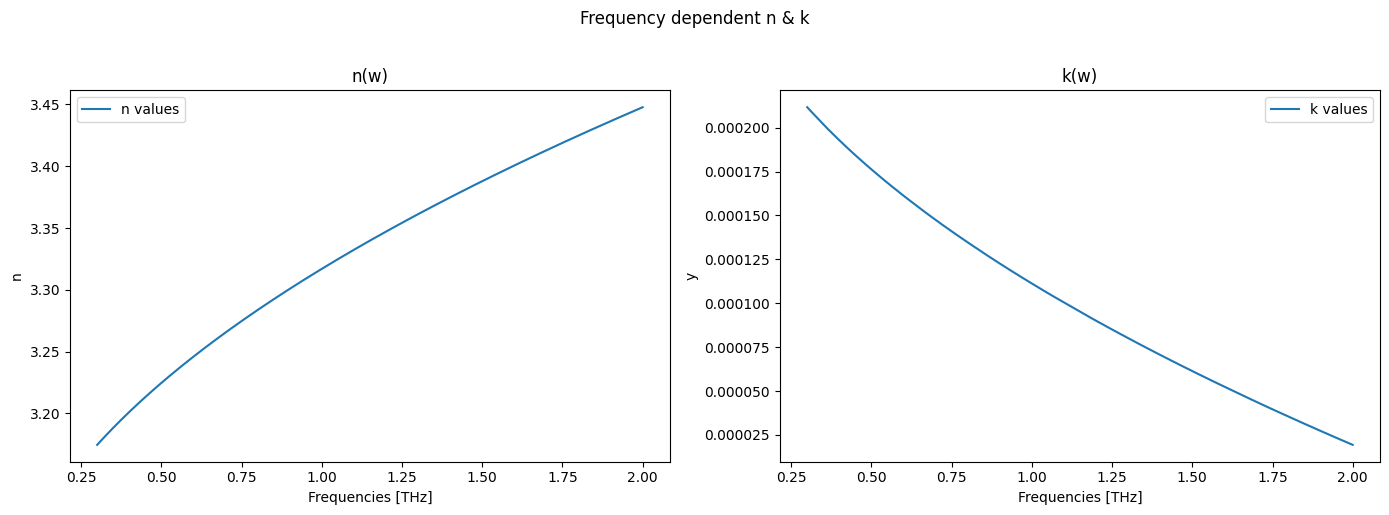

In [2]:
thickness = 3 * 1e-3
# Setup frequency arrays
frequency_bounds = [0.3, 2]
full_w_THz = np.linspace(0.3,frequency_bounds[1], 1000)
full_w_THz = torch.tensor(full_w_THz, dtype=torch.float32)

# Convert to angular freqs for calcs
full_w = full_w_THz * 2 * np.pi * 1e12

n = np.sqrt(0.1 * (full_w_THz + 0.005)) + 3
k = ((np.sqrt(0.000004 * full_w_THz) + 3)**-1) - 0.333

# Create the first subplot (assuming 'data1' is your first dataset)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# First plot: Approximate values of n from NR solution
sns.lineplot(x=full_w_THz, y=n, label="n values", ax=ax1)
ax1.set_title('n(w)')
ax1.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax1.set_xlabel('Frequencies [THz]')
ax1.set_ylabel('n')

# Second plot (assuming 'data2' is your second dataset with x and y values)
sns.lineplot(x=full_w_THz, y=k, label="k values", ax=ax2)
ax2.set_title('k(w)')
ax2.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
ax2.set_xlabel('Frequencies [THz]')
ax2.set_ylabel('y')

# Adjust layout and add main title if needed
plt.suptitle('Frequency dependent n & k', y=1.02)
plt.tight_layout()
plt.legend()
plt.show()

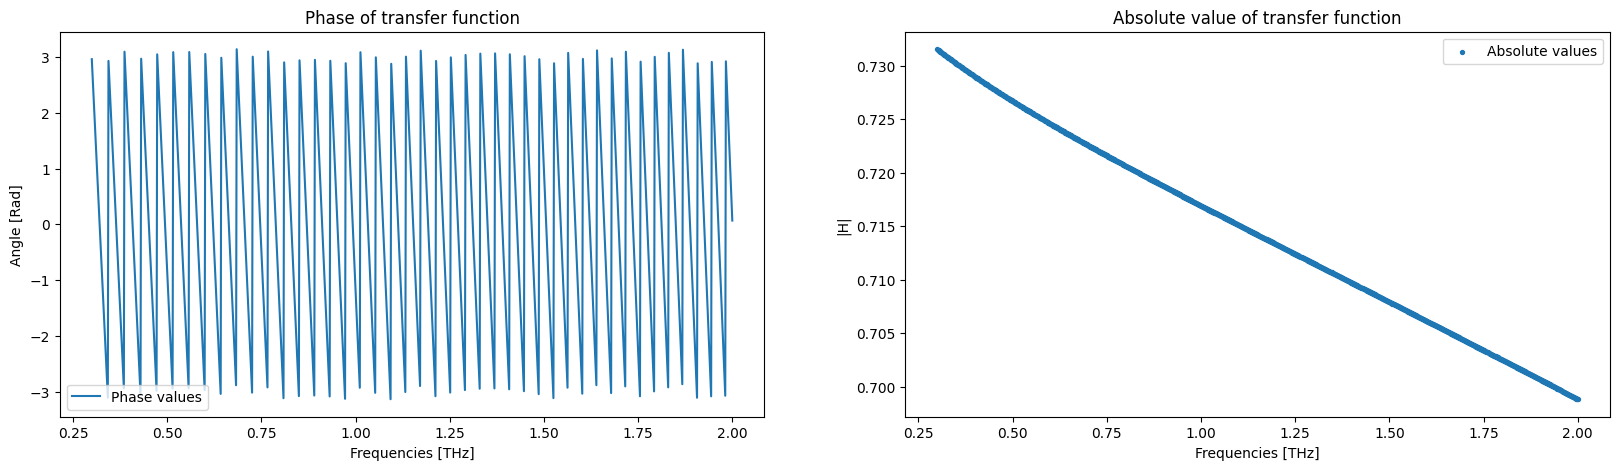

In [3]:
n_complex = n + 1j*k

freq_dep_H = H_th_function(n_complex, w=full_w, length=thickness)

# Break down into components
freq_dep_H_abs = torch.abs(freq_dep_H)
freq_dep_H_phase = torch.angle(freq_dep_H)

unwrapped_phase = torch_unwrap(freq_dep_H_phase)

plot_transfer(full_w_THz, absolute_values=freq_dep_H_abs, phase_values=freq_dep_H_phase)

Epoch 0: Loss = 1.096197247505188 (Best Loss = 1.096197247505188)
Epoch 500: Loss = 1.467542976030245e-08 (Best Loss = 1.467542976030245e-08)
Epoch 1000: Loss = 1.2499733192949947e-10 (Best Loss = 1.1274546574124855e-10)
Epoch 1500: Loss = 1.158022477909526e-08 (Best Loss = 1.0546048756499005e-10)
Epoch 2000: Loss = 1.5002664000007826e-08 (Best Loss = 1.0546048756499005e-10)
Epoch 2500: Loss = 4.9519371714268345e-08 (Best Loss = 1.0546048756499005e-10)


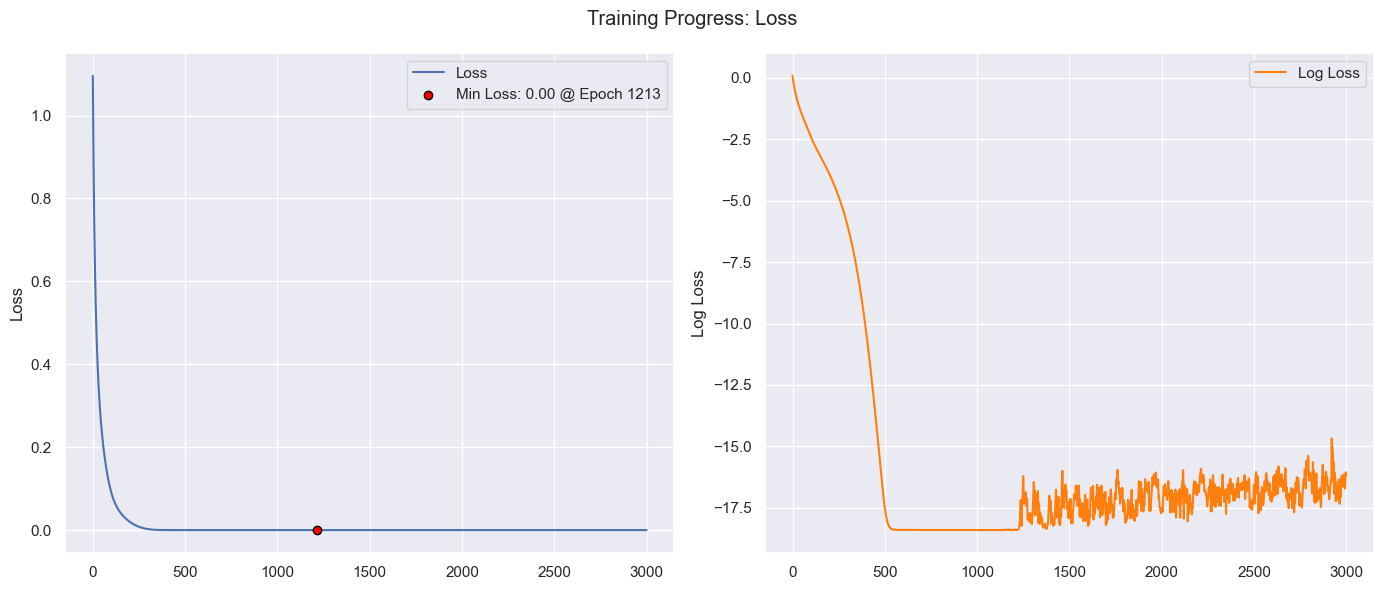

In [4]:
freq_model = FrequencyDependentModel(w_tensor=full_w, d=thickness, ICs_n=3.3, ICs_k=0.0001)

# Setup Optimizer and scheduler
optimizer_freq = torch.optim.Adam(freq_model.parameters(), lr=5e-4)


freq_model.train_model(freq_dep_H, H_th_function, complex_real_imag_loss, epochs=3000, optimizer=optimizer_freq)
plot_training_progress(freq_model.loss_history)

In [5]:
n_w = freq_model.best_n.detach().cpu().numpy()
k_w = freq_model.best_k.detach().cpu().numpy()

frequencies = full_w_THz

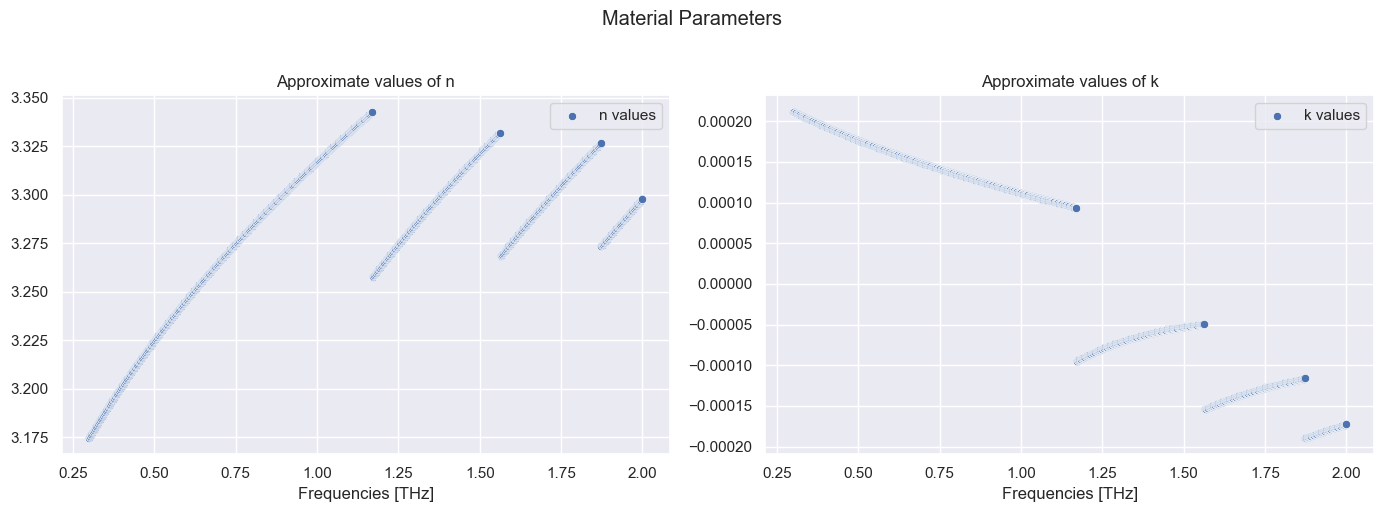

In [6]:
plot_material_params(frequencies=frequencies, n=n_w, k=k_w)

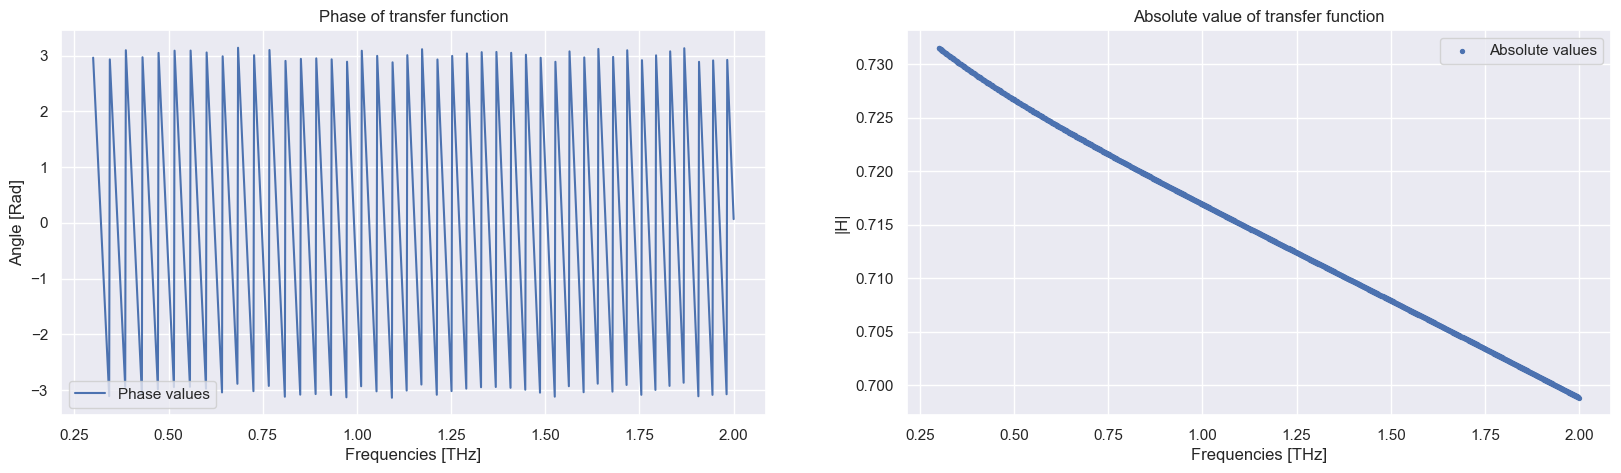

In [7]:
n_complex_w = n_w + 1j*k_w
n_complex_w = torch.tensor(n_complex_w, dtype=torch.cfloat)

H_w_recon = H_th_function(n_complex=n_complex_w, w=full_w, length=thickness)

H_w_recon_abs = torch.abs(H_w_recon)
H_w_recon_phase = torch.angle(H_w_recon)

plot_transfer(frequencies, H_w_recon_abs, H_w_recon_phase)

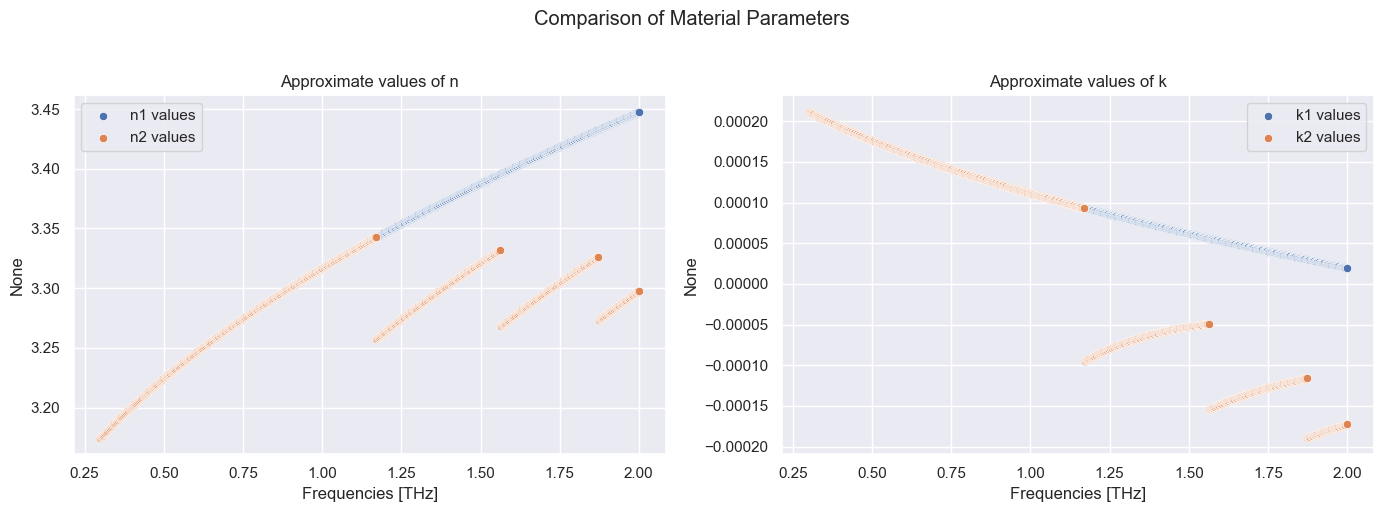

In [8]:
compare_material_params(frequencies=frequencies, n1=n, k1=k, n2=n_w, k2=k_w)

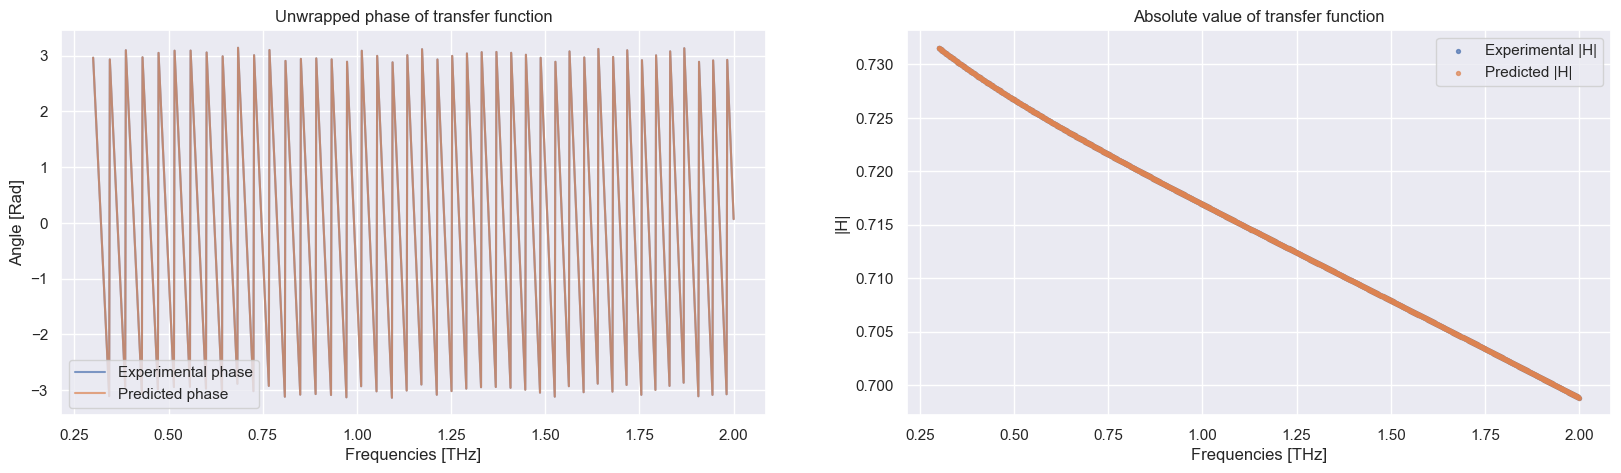

In [9]:
plot_comparison(frequencies=frequencies, exp_abs=freq_dep_H_abs, exp_phase=freq_dep_H_phase, pred_abs=H_w_recon_abs, pred_phase=H_w_recon_phase)

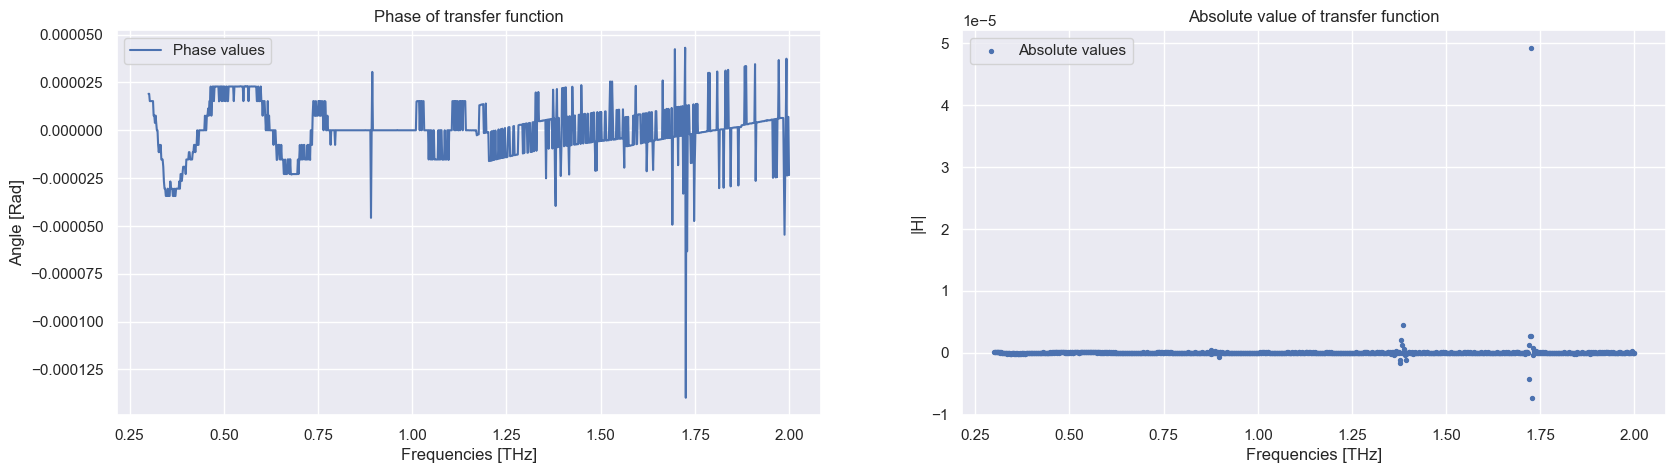

In [10]:
# Plot the errors at each frequency point

delta_phase = freq_dep_H_phase - H_w_recon_phase
delta_abs = freq_dep_H_abs - H_w_recon_abs

plot_transfer(frequencies=frequencies, absolute_values=delta_abs, phase_values=delta_phase)

## Compare to NR method on the same data

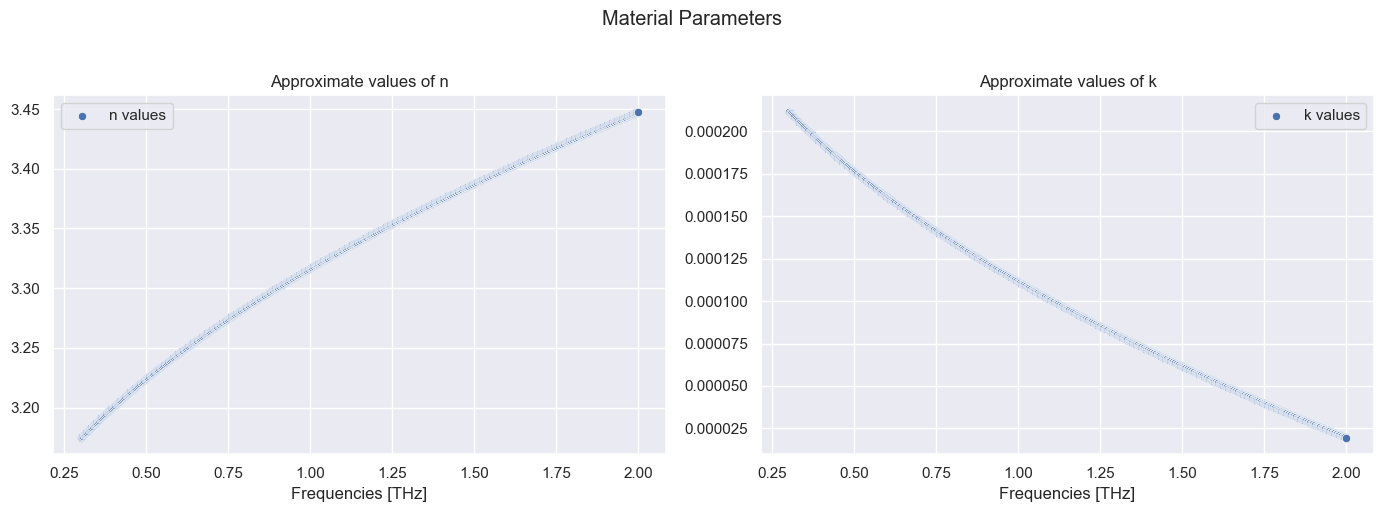

In [11]:
NR_fit = newton_raphson_fitting(H_th_function=H_th_function, H_prime_function=H_prime_function, 
                                f_interp=full_w_THz, A_exp=freq_dep_H_abs, ph_extrapolated=unwrapped_phase, 
                                Length=thickness, n_0=3.4+0.001j)

NR_fit_n = NR_fit.real
NR_fit_k = NR_fit.imag

plot_material_params(full_w_THz, NR_fit_n, NR_fit_k)

## Test Independent Frequency model

In [13]:
# Initialize the model
indep_freq_model = IndependentFrequencyModel(full_w, thickness=thickness, H_exp=freq_dep_H, n_real_init=3.2, n_imag_init=0.0001)


n_opt, k_opt = indep_freq_model.optimize()

/Users/theosmith/Documents/MPhys_YiER_Project/Coding/Git_repo/THz-TDS/PINNs/Frequency_dependent/Model/model_freq_dep.py:81: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.freq = torch.tensor(freq, dtype=torch.float32)
/Users/theosmith/Documents/MPhys_YiER_Project/Coding/Git_repo/THz-TDS/PINNs/Frequency_dependent/Model/model_freq_dep.py:82: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.H_exp = torch.tensor(H_exp, dtype=torch.complex64)


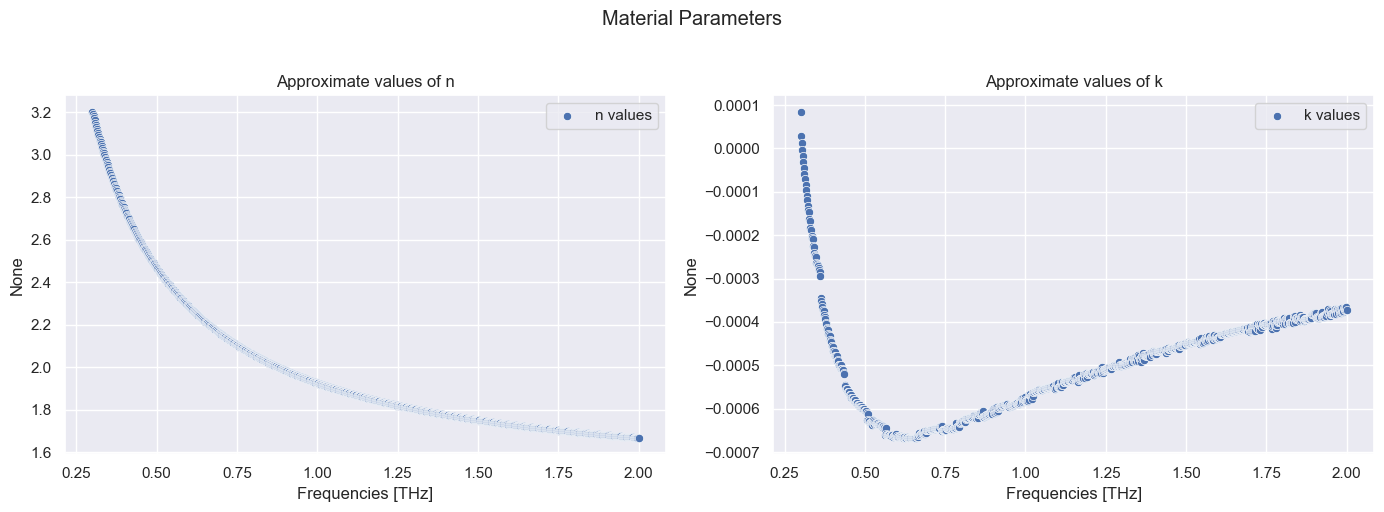

In [14]:
plot_material_params(full_w_THz, n_opt,k_opt)

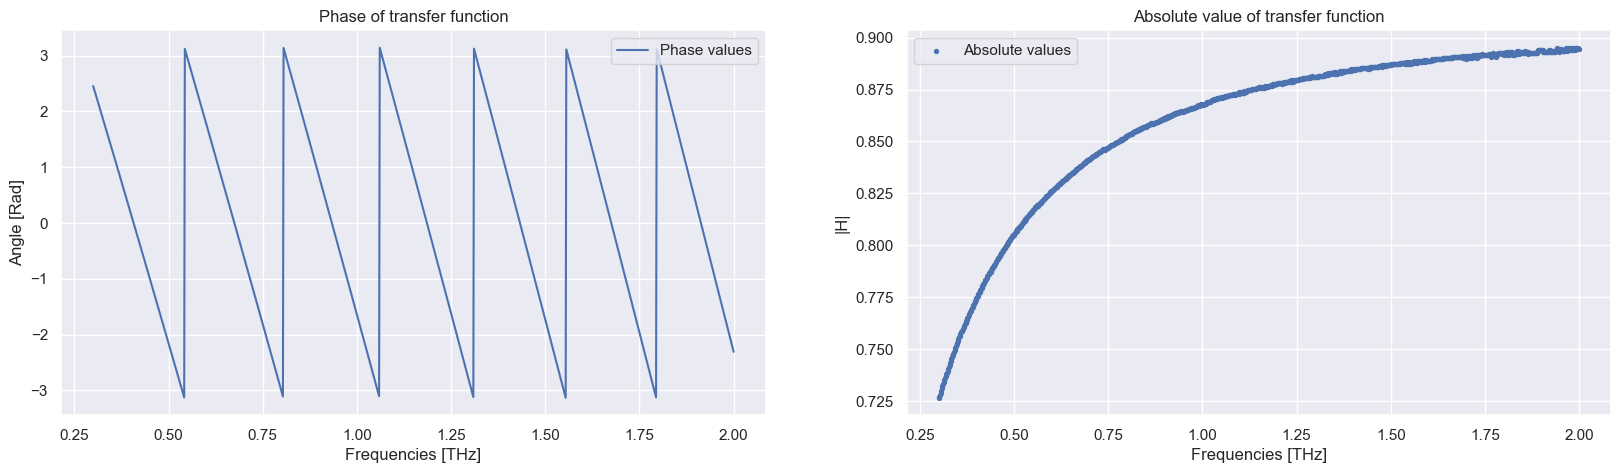

In [15]:
complex_opt = n_opt + 1j*k_opt
H_indep = H_th_function(n_complex=complex_opt, w=full_w, length=thickness)

plot_transfer(frequencies=full_w_THz, absolute_values=torch.abs(H_indep), phase_values=torch.angle(H_indep))